In [1]:
import csv
import pandas as pd
import scipy, numpy
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv('Chatbot User Study Cleaned.csv')

In [4]:
question_id_mapping = pd.read_csv('question_id_mapping.csv')

In [5]:
def QID_to_question(qid):
    return question_id_mapping[question_id_mapping['QuestionID'] == qid]['QuestionText'].iloc[0]

In [6]:
df.shape

(374, 96)

In [7]:
likert_agree_order = ['Strongly disagree', 'Somewhat disagree', 'Neither agree nor disagree', 'Somewhat agree', 'Strongly agree']
likert_knowledgeable_order = ['Not knowledgeable at all', 'Slightly knowledgeable', 'Moderately knowledgeable', 'Very knowledgeable', 'Extremely knowledgeable']
likert_order = ['Strongly disagree', 'Somewhat disagree', 'Neither agree nor disagree', 'Somewhat agree', 'Strongly agree']

In [8]:
import altair as alt
colors = ['#D65F39', '#F5A89E', '#D3D3D3', '#A6C8E3', '#4472C4']
def compute_percentages(df, col="QID33", likert_order=['Strongly disagree', 'Somewhat disagree', 'Neither agree nor disagree', 'Somewhat agree', 'Strongly agree'], text=None):
    response_counts = df[col].value_counts().reindex(likert_order, fill_value=0)

    # Normalize the counts to percentages
    total_responses = response_counts.sum()
    response_percentages = (response_counts / total_responses) * 100
    
    print(response_counts)

    df_temp = pd.DataFrame({'type': likert_order, 'value': response_counts, 'percentage': response_percentages})
    df_temp["percentage_end"] = response_percentages.cumsum() - (response_percentages.iloc[0] + response_percentages.iloc[1] + response_percentages.iloc[2] / 2)
    df_temp["percentage_start"] = df_temp["percentage_end"] - response_percentages
    df_temp["question"] = QID_to_question(col) if text is None else text

    return df_temp

### Chatbot Usages

QID5
WhatsApp    244
Discord      83
Telegram     40
Viber         6
LINE          1
Name: count, dtype: int64


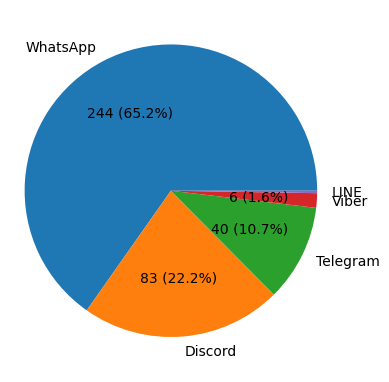

In [9]:
response_counts = df['QID5'].value_counts()
print(response_counts)
plt.figure(figsize=(4, 4))

# Custom autopct function to display count and percentage
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100.*sum(all_vals)))  # Calculate the absolute count
    if absolute == 1:
        return ""
    return f"{absolute} ({pct:.1f}%)"

plt.pie(response_counts, labels=response_counts.index, 
        autopct=lambda pct: autopct_format(pct, response_counts), 
        startangle=0)
plt.axis('equal')
plt.tight_layout()

plt.savefig('figures/platform.pdf')
plt.show()

How often do you notice chatbots in group chats, including seeing them send messages or actively searching for their existence?
How often do you interact with chatbots in group chats, including actively tagging/mentioning chatbots in your messages, chatbots replying to your messages, or chatbots reading your messages?
QID7
Daily                              146
4-6 times per week                  81
2-3 times per week                  83
Once or less than once per week     64
Name: count, dtype: int64
QID12
Daily                               94
4-6 times per week                  78
2-3 times per week                  75
Once or less than once per week    117
Name: count, dtype: int64


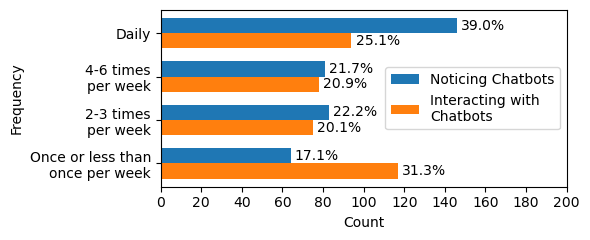

In [10]:
print(QID_to_question('QID7'))
print(QID_to_question('QID12'))

# Define the frequency order
frequency_order = ['Daily', '4-6 times per week', '2-3 times per week', 'Once or less than once per week']
y_labels = ['Daily', '4-6 times\nper week', '2-3 times\nper week', 'Once or less than\nonce per week']

# Retrieve counts for QID7 and QID12 and reindex to the specified order
qid7_counts = df['QID7'].value_counts().sort_values(ascending=False).reindex(frequency_order)
qid12_counts = df['QID12'].value_counts().sort_values(ascending=False).reindex(frequency_order)
print(qid7_counts)
print(qid12_counts)

# Calculate totals for percentages
total_qid7 = df['QID7'].count()
total_qid12 = df['QID12'].count()

# Set up the y locations and bar width for the grouped horizontal bar chart
y = np.arange(len(frequency_order))
bar_height = 0.35

plt.figure(figsize=(6, 2.5))
bars1 = plt.barh(y - bar_height/2, qid7_counts.values, height=bar_height, label='Noticing Chatbots')
bars2 = plt.barh(y + bar_height/2, qid12_counts.values, height=bar_height, label='Interacting with\nChatbots')

# Annotate each bar with its corresponding percentage
for bar in bars1:
    width = bar.get_width()
    percentage = (width / total_qid7 * 100) if total_qid7 > 0 else 0
    plt.text(width + 2, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%', 
             ha='left', va='center', fontsize=10)

for bar in bars2:
    width = bar.get_width()
    percentage = (width / total_qid12 * 100) if total_qid12 > 0 else 0
    plt.text(width + 2, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%', 
             ha='left', va='center', fontsize=10)

plt.yticks(y, y_labels)
plt.ylabel('Frequency')
plt.xlabel('Count')
plt.xticks(np.arange(0, 201, 20))
plt.gca().invert_yaxis()
plt.legend()

plt.tight_layout()
plt.savefig('figures/notice_interact_frequency.pdf')
plt.show()

What purposes do you use chatbots for in group chats? Select all that apply.


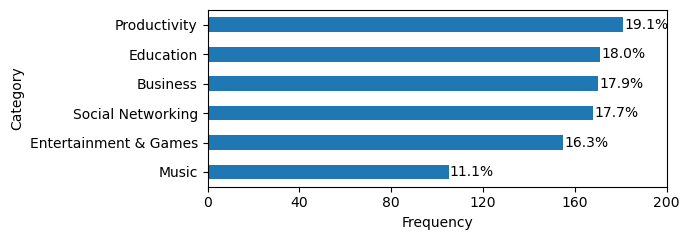

In [11]:
print(QID_to_question('QID14'))
import re

# Define the expected options
options = [
    "Business",
    "Productivity",
    "Developer Tools",
    "Books",
    "Education",
    "Entertainment & Games",
    "Finance",
    "Food & Drink",
    "Graphics & Design",
    "Health & Fitness",
    "News & Magazines",
    "Music",
    "Photo & Video",
    "Social Networking",
    "Travel"   
]

pattern = re.compile(r',(?!(?:[^(]*\)))')
responses_split = df['QID14'].apply(lambda x: x.split(','))
all_responses = responses_split.explode().str.strip()
response_counts = all_responses.value_counts()
response_counts = response_counts.reindex(options, fill_value=0)
response_counts = response_counts.sort_values(ascending=False)

response_counts = response_counts.head(6)

plt.figure(figsize=(7, 2.5))
ax = response_counts.plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.xticks(np.arange(0, 221, 40))  # Adjust this if necessary for horizontal
plt.gca().invert_yaxis()

# Calculate total responses to compute percentages
total_responses = response_counts.sum()

# Annotate each bar with its percentage
for bar in ax.patches:
    width = bar.get_width()
    percentage = (width / total_responses) * 100 if total_responses > 0 else 0
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%', 
            ha='left', va='center', fontsize=10)  # Adjusted text alignment for horizontal bars

plt.tight_layout()
plt.savefig('figures/purposes.pdf')
plt.show()


What types of group chats have you seen chatbots in? Select all that apply. - Selected Choice


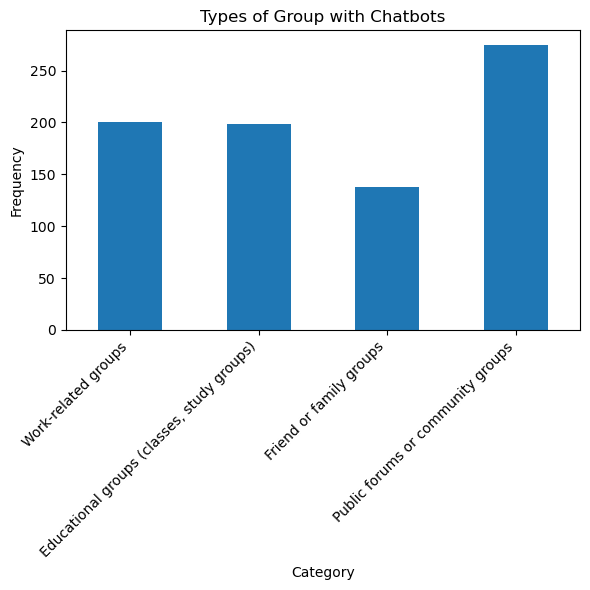

In [12]:
print(QID_to_question('QID13'))
import re
options = [
    "Work-related groups",
    "Educational groups (classes, study groups)",
    "Friend or family groups",
    "Public forums or community groups",
    
]

pattern = re.compile(r',(?!(?:[^(]*\)))')
responses_split_corrected = df['QID13'].apply(lambda x: pattern.split(x))
all_responses_corrected = responses_split_corrected.explode().str.strip()
response_counts_corrected = all_responses_corrected.value_counts()
response_counts_corrected = response_counts_corrected.reindex(options, fill_value=0)

plt.figure(figsize=(6, 6))
response_counts_corrected.plot(kind='bar')
plt.title('Types of Group with Chatbots')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

QID16
Yes         204
No          118
Not sure     52
Name: count, dtype: int64 QID22
Yes         327
Not sure     26
No           21
Name: count, dtype: int64


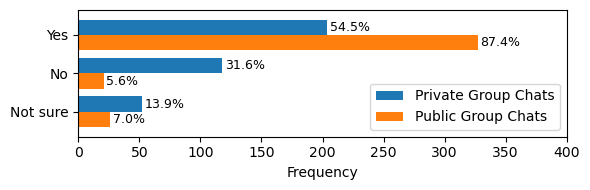

In [13]:
# Count the occurrences of each response for both questions
qid16_counts = df['QID16'].value_counts()
qid22_counts = df['QID22'].value_counts()
print(qid16_counts, qid22_counts)

# Create a dataframe for easier plotting side-by-side
response_comparison = pd.DataFrame({
    'Private Group Chats': qid16_counts,
    'Public Group Chats': qid22_counts
}).reindex(['Yes', 'No', 'Not sure'], fill_value=0)

# Plotting the side-by-side horizontal bar chart
ax = response_comparison.plot(kind='barh', figsize=(6, 2), width=0.8)
# plt.title('Chatbot Noticeability\nin Private vs Public Group')
plt.xlabel('Frequency')
# plt.ylabel('Response Options')
plt.xticks(np.arange(0, 401, 50))
plt.gca().invert_yaxis()

# Calculate totals for each group column to compute percentages
totals = response_comparison.sum(axis=0)

# Annotate each bar with its percentage relative to its group
n_columns = len(response_comparison.columns)
for i, bar in enumerate(ax.patches):
    # Determine which group this bar belongs to: the bars are ordered by category, then by group.
    row_idx = i // n_columns
    col_idx = i % n_columns
    total = totals[response_comparison.columns[col_idx]]
    percentage = (bar.get_width() / total * 100) if total > 0 else 0
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%', 
            ha='left', va='center', fontsize=9)  # Adjusted for horizontal layout

plt.tight_layout()
plt.savefig('figures/noticeability.pdf')
plt.show()


### User's Active Countermeasure
When do users check for the presence of chatbots?

In [14]:
options = [
    "When I first join a group",
    "When a new bot is added into the group",
    "When a bot is removed from the group",
    "When I notice unusual activity in the group",
    "I check every now and then to see if anything has changed"
]

responses_qid20_cleaned = df['QID20'].dropna().apply(lambda x: x.split(',')).explode().str.strip()
responses_qid26_cleaned = df['QID26'].dropna().apply(lambda x: x.split(',')).explode().str.strip()

# Count the occurrences of each response option for both columns
qid20_counts_cleaned = responses_qid20_cleaned.value_counts()
qid26_counts_cleaned = responses_qid26_cleaned.value_counts()


# Create a dataframe for percentage distribution
response_comparison_percentage_individual = pd.DataFrame({
    'Private Group': qid20_counts_cleaned,
    'Public Group': qid26_counts_cleaned
}).reindex(options, fill_value=0)
response_comparison_percentage_individual

,Private Group,Public Group
When I first join a group,94,156
When a new bot is added into the group,62,90
When a bot is removed from the group,20,26
When I notice unusual activity in the group,67,107
I check every now and then to see if anything has changed,48,81


In [15]:
# Perform the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(response_comparison_percentage_individual.to_numpy())

# Print the results
print(f"Chi-Square statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-Square statistic: 0.9723817581246751
p-value: 0.9139545004775325
Degrees of freedom: 4
Expected frequencies:
[[ 96.87083888 153.12916112]
 [ 58.89747004  93.10252996]
 [ 17.82423435  28.17576565]
 [ 67.42210386 106.57789614]
 [ 49.98535286  79.01464714]]


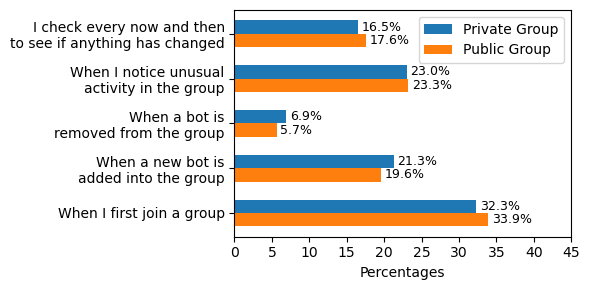

In [16]:
# Calculate totals for each group
private_total = response_comparison_percentage_individual['Private Group'].sum()
public_total = response_comparison_percentage_individual['Public Group'].sum()

# Calculate percentage for each option in both groups
private_pct = response_comparison_percentage_individual['Private Group'] / private_total * 100
public_pct = response_comparison_percentage_individual['Public Group'] / public_total * 100

# Set up positions for grouped horizontal bars
y_positions = np.arange(len(response_comparison_percentage_individual))
bar_height = 0.3

fig, ax = plt.subplots(figsize=(6, 3))

# Plot bars for each group
bars_private = ax.barh(y_positions + bar_height/2,
                         private_pct,
                         height=bar_height,
                         label='Private Group')

bars_public = ax.barh(y_positions - bar_height/2,
                        public_pct,
                        height=bar_height,
                        label='Public Group')

# Annotate bars with the percentage text
for i, bar in enumerate(bars_private):
    width = bar.get_width()
    pct_text = f"{private_pct.iloc[i]:.1f}%"
    # Place text just to the right of the bar
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, pct_text,
            va='center', color='black', fontsize=9)

for i, bar in enumerate(bars_public):
    width = bar.get_width()
    pct_text = f"{public_pct.iloc[i]:.1f}%"
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, pct_text,
            va='center', color='black', fontsize=9)

# Customize the axes and labels
ax.set_xlabel('Percentages')
ax.set_xticks(np.arange(0, 46, 5))
ax.set_yticks(y_positions)
ax.set_yticklabels(['When I first join a group', 'When a new bot is\nadded into the group',
       'When a bot is\nremoved from the group',
       'When I notice unusual\nactivity in the group',
       'I check every now and then\nto see if anything has changed'])
# ax.set_title('When Users Check for Chatbots')
ax.legend()
plt.tight_layout()
plt.savefig('figures/checking_chatbot_time.pdf')
plt.show()

How often do users check for the presence of the chatbots when joining.

In [17]:
print(QID_to_question("QID17"))
options = ["Never", "Rarely", "Sometimes", "Usually", "Always"]

responses_qid17_cleaned = df['QID17'].dropna().apply(lambda x: x.split(',')).explode().str.strip()
responses_qid23_cleaned = df['QID23'].dropna().apply(lambda x: x.split(',')).explode().str.strip()

# Count the occurrences of each response option for both columns
qid17_counts_cleaned = responses_qid17_cleaned.value_counts()
qid23_counts_cleaned = responses_qid23_cleaned.value_counts()

# Create a dataframe for percentage distribution
response_comparison_percentage_individual = pd.DataFrame({
    'Private Group': qid17_counts_cleaned,
    'Public Group': qid23_counts_cleaned
}).reindex(options, fill_value=0)
response_comparison_percentage_individual

How often do you check for the presence of chatbots whenever you join private group chats?


,Private Group,Public Group
Never,20,35
Rarely,54,86
Sometimes,68,89
Usually,39,62
Always,23,55


In [18]:
# Perform the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(response_comparison_percentage_individual.to_numpy())

# Print the results
print(f"Chi-Square statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-Square statistic: 4.3202228900415705
p-value: 0.36439962210432475
Degrees of freedom: 4
Expected frequencies:
[[21.1299435  33.8700565 ]
 [53.78531073 86.21468927]
 [60.31638418 96.68361582]
 [38.80225989 62.19774011]
 [29.96610169 48.03389831]]


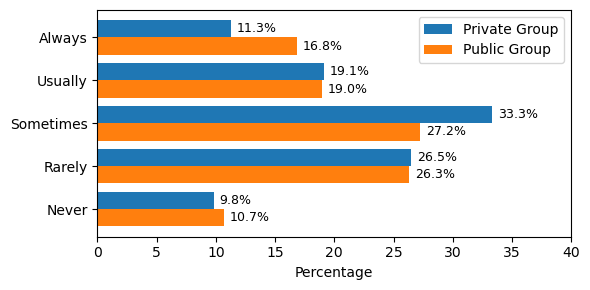

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assume response_comparison_percentage_individual is already defined
# response_comparison_percentage_individual = pd.DataFrame({
#     'Private Group': qid17_counts_cleaned,
#     'Public Group': qid23_counts_cleaned
# }).reindex(options, fill_value=0)

# Calculate total responses for each group
private_total = response_comparison_percentage_individual['Private Group'].sum()
public_total = response_comparison_percentage_individual['Public Group'].sum()

# Calculate percentage for each option in both groups
private_pct = response_comparison_percentage_individual['Private Group'] / private_total * 100
public_pct = response_comparison_percentage_individual['Public Group'] / public_total * 100

# Set up positions for grouped horizontal bars
y_positions = np.arange(len(response_comparison_percentage_individual))
bar_height = 0.4

fig, ax = plt.subplots(figsize=(6, 3))

# Plot bars for each group
bars_private = ax.barh(y_positions + bar_height/2,
                       private_pct,
                       height=bar_height, label='Private Group')

bars_public = ax.barh(y_positions - bar_height/2,
                      public_pct,
                      height=bar_height, label='Public Group')

# Annotate bars with percentage text
for i, bar in enumerate(bars_private):
    width = bar.get_width()
    pct_text = f"{private_pct.iloc[i]:.1f}%"
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, pct_text,
            va='center', color='black', fontsize=9)

for i, bar in enumerate(bars_public):
    width = bar.get_width()
    pct_text = f"{public_pct.iloc[i]:.1f}%"
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, pct_text,
            va='center', color='black', fontsize=9)

# Customize the axes and labels
ax.set_xlabel('Percentage')
ax.set_xticks(np.arange(0, 41, 5))
# ax.set_ylabel('Response Options')
ax.set_yticks(y_positions)
ax.set_yticklabels(response_comparison_percentage_individual.index)
# ax.set_title('Checking Chatbots When First Joining a Group')
ax.legend()

plt.tight_layout()
plt.savefig('figures/checking_chatbot_first.pdf')
plt.show()


### Privacy Concerns of Chatbots

In [20]:
def plot_likert(df, categories, title="", image_size=(8, 2), question_labels=None, legend=True):
    questions = list(df.columns)
    num_categories = len(categories)
    
    # If question_labels is not provided, default to column names
    if question_labels is None:
        question_labels = questions

    # Prepare the data: drop NaN and calculate percentages
    counts = df.apply(lambda col: col.value_counts(normalize=True)*100).reindex(categories).fillna(0)
    
    # Separate out the disagree, neutral, and agree segments
    disagree = counts.iloc[: num_categories // 2]  # e.g. rows 0..1 => Strongly/Somewhat Disagree
    neutral  = counts.iloc[num_categories // 2 : num_categories // 2 + 1]  # row 2 => Neither
    agree    = counts.iloc[num_categories // 2 + 1 :]  # rows 3.. => Somewhat/Strongly Agree

    fig, ax = plt.subplots(figsize=image_size)

    colors_disagree = ['#d73027', '#f46d43']
    colors_agree = ['#abd9e9', '#4575b4']
    neutral_color = '#fdae61'

    for i, question in reversed(list(enumerate(questions))):
        # How wide is the neutral category (for this question)?
        neutral_count = neutral[question].values[0]
        neutral_half = neutral_count / 2.0

        # Pull out the actual disagree values in order
        strongly_disagree = disagree.iloc[0][question]
        somewhat_disagree = disagree.iloc[1][question]

        # Pull out the agree values
        somewhat_agree = agree.iloc[0][question]
        strongly_agree = agree.iloc[1][question]

        ax.barh(
            question_labels[i],
            -neutral_half-somewhat_disagree,
            left=-neutral_half,
            color=colors_disagree[0],
            edgecolor='white'
        )

        ax.barh(
            question_labels[i],
            -somewhat_disagree,
            left=-neutral_half,
            color=colors_disagree[1],
            edgecolor='white'
        )

        ax.barh(
            question_labels[i],
            neutral_count,
            left=-neutral_half,
            color=neutral_color,
            edgecolor='white'
        )

        ax.barh(
            question_labels[i],
            somewhat_agree,
            left=neutral_half,
            color=colors_agree[0],
            edgecolor='white'
        )
        # 5) Plot strongly_agree to the right of that
        ax.barh(
            question_labels[i],
            strongly_agree,
            left=neutral_half + somewhat_agree,
            color=colors_agree[1],
            edgecolor='white'
        )

    # Now figure out the largest negative and positive extents
    min_disagree = min(-disagree[question].sum() - neutral[question].values[0] / 2 for question in questions)
    max_agree = max(agree[question].sum() + neutral[question].values[0] / 2 for question in questions)
    
    # Set the range and tick intervals (adjust as needed)
    min_tick = (min_disagree // 10 - 1) * 10
    max_tick = (max_agree // 10 + 1) * 10
    ax.set_xticks(np.arange(min_tick, max_tick + 10, 10))  # Ensure ticks span the correct range

    # Construct a custom legend so the colors match the labels in the correct order
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(facecolor=colors_disagree[0], label=categories[0]),
        Patch(facecolor=colors_disagree[1], label=categories[1]),
        Patch(facecolor=neutral_color,       label=categories[2]),
        Patch(facecolor=colors_agree[0],     label=categories[3]),
        Patch(facecolor=colors_agree[1],     label=categories[4]),
    ]
    
    if legend:
        ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Percentage of Responses')
    ax.set_title(title)
    plt.tight_layout()
    return plt


Do people think chatbots collect too much information?

I think chatbots accessing more information than necessary could cause privacy issues in public group chats.
I think chatbots accessing more information than necessary could cause privacy issues in private group chats.


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

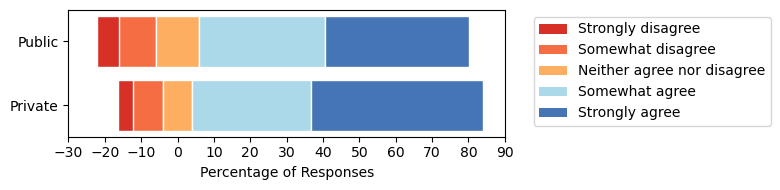

In [21]:
print(QID_to_question("QID38"))
print(QID_to_question("QID39"))

# df_temp = pd.concat([
#     compute_percentages(df, "QID38", text="Public").reset_index(drop=True),
#     compute_percentages(df, "QID39", text="Private").reset_index(drop=True)])
# color_scale = alt.Scale(domain=likert_order, range=colors)
# y_axis = alt.Axis(title="Question", offset=5, ticks=False, minExtent=60, domain=False)

# alt.Chart(df_temp).mark_bar().encode(
#     x="percentage_start:Q",
#     x2="percentage_end:Q",
#     y=alt.Y("question:N").axis(y_axis),
#     color=alt.Color("type:N").title("Response").scale(color_scale),
# )

plot_likert(df[["QID38", "QID39"]], likert_agree_order, question_labels=["Public", "Private"])

Would you still use chatbots if you knew what they had access to?

I would still use the chatbot after knowing what information it had access to.


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

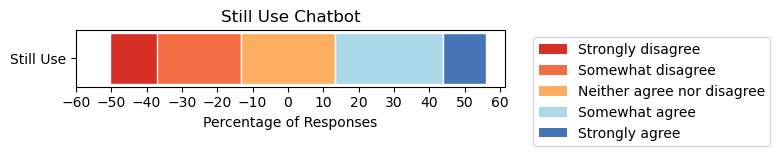

In [22]:
print(QID_to_question("QID36"))
plot_likert(df[["QID36"]], likert_agree_order, title="Still Use Chatbot", question_labels=["Still Use"], image_size=(8, 1.5))

### User's Understanding of Privacy Concerns

Do users think themselve understanding chatbots' permissions?

To what extent are you familiar with what information chatbots on [QID5-ChoiceGroup-SelectedChoices] can access in group chats?


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

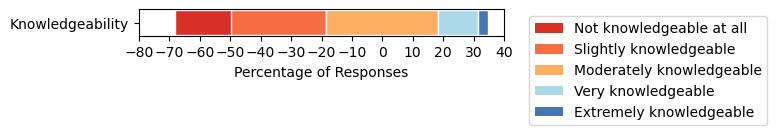

In [23]:
print(QID_to_question("QID27"))
plot_likert(df[["QID27"]], likert_knowledgeable_order, title="", question_labels=["Knowledgeability"], image_size=(8, 1))

In [24]:
compute_percentages(df, "QID27", likert_knowledgeable_order).reset_index(drop=True)[['type', 'value', 'percentage']]

QID27
Not knowledgeable at all     58
Slightly knowledgeable      117
Moderately knowledgeable    138
Very knowledgeable           48
Extremely knowledgeable      13
Name: count, dtype: int64


,type,value,percentage
0,Not knowledgeable at all,58,15.508021
1,Slightly knowledgeable,117,31.283422
2,Moderately knowledgeable,138,36.898396
3,Very knowledgeable,48,12.834225
4,Extremely knowledgeable,13,3.475936


Do user get it right?

In [25]:
"""
Chatbot-permission grader.

Key ideas
---------
1. Every option is labelled `MUST`, `OPTIONAL`, or `FORBIDDEN`.
   * "Always accessible"  -> MUST
   * "Config-dependent"   -> OPTIONAL
   * "Wrong"              -> FORBIDDEN
2. Some OPTIONAL options belong to a *cluster* that has to be
   answered all-or-none.  Cluster membership is recorded once,
   in `CLUSTERS`.
3. Grading is therefore pure data lookup; nothing is hard-coded
   per platform or per question.

Scoring rule
------------
For a single question we award **one point per option** if the
response is consistent with the label, i.e.

* MUST      – the respondent ticked it
* FORBIDDEN – the respondent left it blank
* OPTIONAL  – the label is OPTIONAL **and**
              (a) the option’s cluster (if any) is “all” or “none”
              (b) OR the option is not in a cluster at all

If the respondent selected “I am not sure” the score is 0.
"""

from enum import Enum
from typing import Dict, List, Set

# 1)  Labels
class Rule(Enum):
    MUST      = 1      # must be ticked
    OPTIONAL  = 0      # can be ticked or not
    FORBIDDEN = -1     # must NOT be ticked


# 2)  Master list of options
OPTIONS = {
    "QID28": [
        "All messages sent in the chat, including those that are later deleted.",
        "All messages sent in the chat, excluding those that are later deleted.",
        "Only messages needed for the normal operation of the chatbot.",
        "Messages where the chatbot is directly mentioned or addressed."
    ],
    "QID29": [
        "The content of the message itself.",
        "The message metadata, such as time sent.",
        "The sender’s username. A user has the same username in different groups.",
        "The sender’s pseudonym. A user has different pseudonyms in different groups.",
        "The sender’s metadata (other than the username), such as profile picture, gender, and email addresses."
    ],
    "QID30": [
        "The name of the group.",
        "The list of group members’ usernames.",
        "The profile pictures of group members.",
        "The roles or statuses of group members (e.g., moderator)."
    ]
}

# 3)  Answer key (add the missing platforms if you need them)
KEY: Dict[str, Dict[str, Dict[str, Rule]]] = {
    "WhatsApp": {
        "QID28": {
            OPTIONS["QID28"][0]: Rule.MUST,
            OPTIONS["QID28"][1]: Rule.FORBIDDEN,
            OPTIONS["QID28"][2]: Rule.FORBIDDEN,
            OPTIONS["QID28"][3]: Rule.FORBIDDEN
        },
        "QID29": {
            OPTIONS["QID29"][0]: Rule.MUST,
            OPTIONS["QID29"][1]: Rule.MUST,
            OPTIONS["QID29"][2]: Rule.MUST,
            OPTIONS["QID29"][3]: Rule.FORBIDDEN,
            OPTIONS["QID29"][4]: Rule.MUST
        },
        "QID30": {
            opt: Rule.MUST for opt in OPTIONS["QID30"]
        }
    },

    "Discord": {
        "QID28": {
            OPTIONS["QID28"][0]: Rule.OPTIONAL,   # vetted bot
            OPTIONS["QID28"][1]: Rule.FORBIDDEN,
            OPTIONS["QID28"][2]: Rule.FORBIDDEN,
            OPTIONS["QID28"][3]: Rule.OPTIONAL    # un-vetted bot
        },
        "QID29": {
            OPTIONS["QID29"][0]: Rule.OPTIONAL,      
            OPTIONS["QID29"][1]: Rule.MUST,
            OPTIONS["QID29"][2]: Rule.MUST,
            OPTIONS["QID29"][3]: Rule.FORBIDDEN,
            OPTIONS["QID29"][4]: Rule.MUST
        },
        "QID30": {
            OPTIONS["QID30"][0]: Rule.MUST,       # group name
            OPTIONS["QID30"][1]: Rule.OPTIONAL,   # the three below travel together
            OPTIONS["QID30"][2]: Rule.OPTIONAL,
            OPTIONS["QID30"][3]: Rule.OPTIONAL
        }
    },

    "Telegram": {
        "QID28": {
            OPTIONS["QID28"][0]: Rule.OPTIONAL,   # privacy-mode off
            OPTIONS["QID28"][1]: Rule.FORBIDDEN,
            OPTIONS["QID28"][2]: Rule.FORBIDDEN,
            OPTIONS["QID28"][3]: Rule.OPTIONAL    # privacy-mode on
        },
        "QID29": {
            OPTIONS["QID29"][0]: Rule.MUST,
            OPTIONS["QID29"][1]: Rule.MUST,
            OPTIONS["QID29"][2]: Rule.MUST,
            OPTIONS["QID29"][3]: Rule.FORBIDDEN,
            OPTIONS["QID29"][4]: Rule.MUST
        },
        "QID30": {
            OPTIONS["QID30"][0]: Rule.MUST,
            OPTIONS["QID30"][1]: Rule.MUST,
            OPTIONS["QID30"][2]: Rule.MUST,
            OPTIONS["QID30"][3]: Rule.MUST
        }
    },

    "LINE": {
        "QID28": {
            OPTIONS["QID28"][0]: Rule.MUST,
            OPTIONS["QID28"][1]: Rule.FORBIDDEN,
            OPTIONS["QID28"][2]: Rule.FORBIDDEN,
            OPTIONS["QID28"][3]: Rule.FORBIDDEN
        },
        "QID29": {
            OPTIONS["QID29"][0]: Rule.MUST,
            OPTIONS["QID29"][1]: Rule.MUST,
            OPTIONS["QID29"][2]: Rule.MUST,
            OPTIONS["QID29"][3]: Rule.FORBIDDEN,
            OPTIONS["QID29"][4]: Rule.MUST
        },
        "QID30": {
            OPTIONS["QID30"][0]: Rule.MUST,
            OPTIONS["QID30"][1]: Rule.OPTIONAL,
            OPTIONS["QID30"][2]: Rule.OPTIONAL,
            OPTIONS["QID30"][3]: Rule.FORBIDDEN
        }
    },

    "Viber": {
        "QID28": {
            OPTIONS["QID28"][0]: Rule.MUST,
            OPTIONS["QID28"][1]: Rule.FORBIDDEN,
            OPTIONS["QID28"][2]: Rule.FORBIDDEN,
            OPTIONS["QID28"][3]: Rule.FORBIDDEN
        },
        "QID29": {
            OPTIONS["QID29"][0]: Rule.MUST,
            OPTIONS["QID29"][1]: Rule.MUST,
            OPTIONS["QID29"][2]: Rule.MUST,
            OPTIONS["QID29"][3]: Rule.FORBIDDEN,
            OPTIONS["QID29"][4]: Rule.MUST
        },
        "QID30": {
            opt: Rule.MUST for opt in OPTIONS["QID30"]
        }
    }
}


# 4)  OPTIONAL clusters (all-or-none)
#      key = (platform, question) -> list[set of options]
CLUSTERS = {
    # Discord – QID30: tick NONE  or  tick ALL THREE (1,2,3)
    ("Discord", "QID30"): [{OPTIONS["QID30"][1], OPTIONS["QID30"][2], OPTIONS["QID30"][3]}],
    # LINE – QID30: tick NONE  or  tick ALL TWO (1, 2)
    ("LINE",    "QID30"): [{OPTIONS["QID30"][1], OPTIONS["QID30"][2]}]
}

SINGLE_CHOICE = {"QID28"} 
NOT_SURE = "I am not sure"


# ------------------------------------------------------------------
# 5)  Turn a Qualtrics string into a Python list  -------------------
# ------------------------------------------------------------------
def parse_selection(cell: str | float, qid: str) -> List[str]:
    """
    Return *exactly* the options the respondent chose for `qid`.

    Qualtrics exports the raw text of every ticked alternative in one
    comma-separated string **without** escaping the commas that already
    exist inside an option label.  (E.g. "...message itself.,The message
    metadata, such as time sent.,The sender’s username…")

    The safest way is therefore: for every known option string,
    ask: “Does this literal substring appear in the cell?”
    """
    if pd.isna(cell):
        return []

    picked = []
    for option in OPTIONS[qid]:
        if option in cell:
            picked.append(option)

    # Checkbox questions also include “I am not sure” if ticked
    if NOT_SURE in cell:
        picked.append(NOT_SURE)

    return picked


# ------------------------------------------------------------------
# 6)  Scoring helpers  ---------------------------------------------
# ------------------------------------------------------------------
def _lenient_cluster_points(chosen: set, cluster: set) -> int:
    """Whichever interpretation yields more points (all-ticked vs none-ticked)."""
    k = len(chosen & cluster)          # ticks inside the cluster
    n = len(cluster)
    return max(k, n - k)


def score_question(platform: str, qid: str, chosen: List[str]) -> int:
    """
    Return the number of correct points for **one** (platform, qid) pair.
    """
    if NOT_SURE in chosen:
        return 0

    chosen_set = set(chosen)
    rulebook   = KEY[platform][qid]

    # ---- 1)  SINGLE-CHOICE QUESTIONS  ---------------------------------
    if qid in SINGLE_CHOICE:
        # must pick exactly ONE option
        if len(chosen_set) != 1:
            return 0
        picked = next(iter(chosen_set))
        return int(rulebook[picked] is not Rule.FORBIDDEN)

    # ---- 2)  MULTI-SELECT QUESTIONS  ----------------------------------
    clusters_here   = CLUSTERS.get((platform, qid), [])
    already_counted = set()
    points          = 0

    # (a) lenient clusters
    for cluster in clusters_here:
        points         += _lenient_cluster_points(chosen_set, cluster)
        already_counted |= cluster

    # (b) all remaining individual options
    for opt, rule in rulebook.items():
        if opt in already_counted:
            continue
        if   rule is Rule.MUST      and opt in chosen_set:     points += 1
        elif rule is Rule.FORBIDDEN and opt not in chosen_set: points += 1
        elif rule is Rule.OPTIONAL:                            points += 1

    return points


# ------------------------------------------------------------------
# 7)  Grade an entire DataFrame  -----------------------------------
# ------------------------------------------------------------------
def grade_dataframe(df: pd.DataFrame, platform_col: str = "QID5") -> pd.DataFrame:
    """
    Adds three new columns  QID28_Score, QID29_Score, QID30_Score
    with the respondent’s points.

    *Assumes* the raw Qualtrics columns for each question are still
    strings exactly like in your example.
    """
    for qid in ("QID28", "QID29", "QID30"):
        df[f"{qid}_Score"] = (
            df.apply(
                lambda row: score_question(
                    row[platform_col],
                    qid,
                    parse_selection(row[qid], qid)
                ),
                axis=1
            )
        )
    return df

df = grade_dataframe(df)

In [26]:
all_correct_df = df[
    (df['QID28_Score'] == 1) &
    (df['QID29_Score'] == 5) &
    (df['QID30_Score'] == 4)
]
all_correct_df.shape

(10, 99)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

########################################################################
# Helpers shared by all three figures
########################################################################
def _count_options(df, platform, qid):
    """Return total respondents and a dict{option -> #ticks}."""
    raw = df.loc[df["QID5"] == platform, qid]
    total = len(raw)
    counts = {opt: 0 for opt in OPTIONS[qid]}
    for cell in raw:
        for opt in parse_selection(cell, qid):
            if opt in counts:
                counts[opt] += 1
    return total, counts


def _hatch_for_rule(platform, qid, option):
    rule = KEY[platform][qid].get(option)
    if rule is Rule.MUST:
        return "///"              # always accessible
    if rule is Rule.OPTIONAL:
        return "..."              # config-dependent
    return ""                     # forbidden → no hatch


def _add_platform_hatch_legend(ax, platforms, colors):
    """Add one coloured patch per platform *plus* the two hatch keys."""
    # colour patches
    patches = [
        mpatches.Patch(facecolor=colors[i], label=plat)
        for i, plat in enumerate(platforms)
    ]
    # hatch patches
    patches += [
        mpatches.Patch(facecolor="white", edgecolor="black",
                       hatch="///", label="Always accessible"),
        mpatches.Patch(facecolor="white", edgecolor="black",
                       hatch="...",  label="Config-dependent")
    ]
    ax.legend(handles=patches, fontsize=9, loc='lower right')


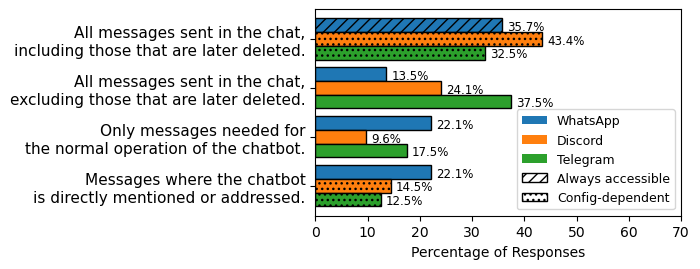

In [28]:
############################################################################
#  QID28  –  each respondent picks exactly ONE alternative
############################################################################
platforms   = ["WhatsApp", "Discord", "Telegram"]
responses   = OPTIONS["QID28"]
responses_l = [
    "All messages sent in the chat,\nincluding those that are later deleted.",
    "All messages sent in the chat,\nexcluding those that are later deleted.",
    "Only messages needed for\nthe normal operation of the chatbot.",
    "Messages where the chatbot\nis directly mentioned or addressed."
]
bar_h       = 0.28
idx         = np.arange(len(responses))
colors      = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(7.1, 2.8))

for i, plat in enumerate(platforms):
    total, counts = _count_options(df, plat, "QID28")
    pct = [counts[opt]/total*100 if total else 0 for opt in responses]
    y   = idx + i*bar_h
    bars = ax.barh(y, pct, bar_h, color=colors[i], edgecolor="black")
    # hatch by rule
    for bar, opt in zip(bars, responses):
        bar.set_hatch(_hatch_for_rule(plat, "QID28", opt))
    # annotate
    for bar, p in zip(bars, pct):
        ax.annotate(f"{p:.1f}%", (bar.get_width()+1, bar.get_y()+bar.get_height()/2 + 0.025),
                    va="center", fontsize=8.5)

ax.set_yticks(idx + bar_h*(len(platforms)-1)/2)
ax.set_yticklabels(responses_l, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel("Percentage of Responses")
ax.set_xticks(np.arange(0, 71, 10))

_add_platform_hatch_legend(ax, platforms, colors)
plt.tight_layout()
plt.savefig("figures/understanding_message_kind.pdf")
plt.show()


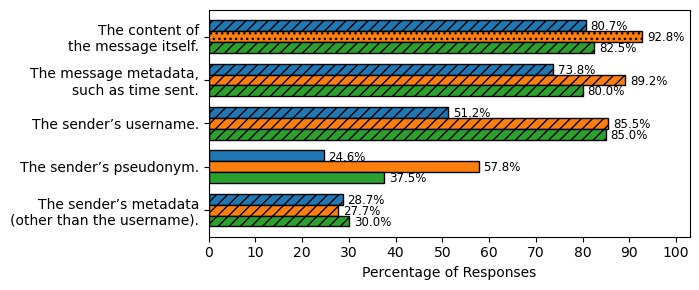

In [29]:
############################################################################
#  QID29  –  multi-select
############################################################################
platforms   = ["WhatsApp", "Discord", "Telegram"]
responses   = OPTIONS["QID29"]
responses_l = [
    "The content of\nthe message itself.",
    "The message metadata,\nsuch as time sent.",
    "The sender’s username.",
    "The sender’s pseudonym.",
    "The sender’s metadata\n(other than the username)."
]
bar_h  = 0.25
idx    = np.arange(len(responses))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(7.1, 3))

for i, plat in enumerate(platforms):
    total, counts = _count_options(df, plat, "QID29")
    pct = [counts[opt]/total*100 if total else 0 for opt in responses]
    y   = idx + i*bar_h
    bars = ax.barh(y, pct, bar_h, color=colors[i], edgecolor="black")
    for bar, opt in zip(bars, responses):
        bar.set_hatch(_hatch_for_rule(plat, "QID29", opt))
    for bar, p in zip(bars, pct):
        ax.annotate(f"{p:.1f}%", (bar.get_width()+1, bar.get_y()+bar.get_height()/2 + 0.027),
                    va="center", fontsize=8.5)

ax.set_yticks(idx + bar_h*(len(platforms)-1)/2)
ax.set_yticklabels(responses_l, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel("Percentage of Responses")
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(right=103)

# _add_platform_hatch_legend(ax, platforms, colors)
plt.tight_layout()
plt.savefig("figures/understanding_message_metadata.pdf")
plt.show()


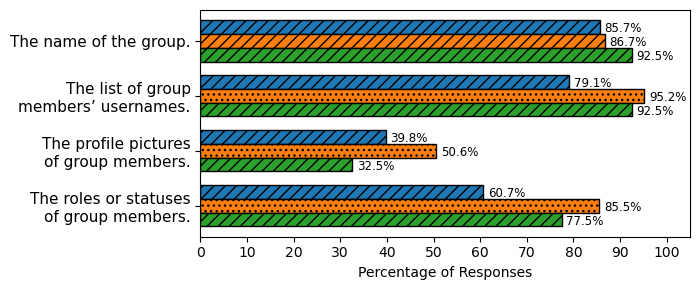

In [30]:
############################################################################
#  QID30  –  multi-select
############################################################################
platforms   = ["WhatsApp", "Discord", "Telegram"]
responses   = OPTIONS["QID30"]
responses_l = [
    "The name of the group.",
    "The list of group\nmembers’ usernames.",
    "The profile pictures\nof group members.",
    "The roles or statuses\nof group members."
]
bar_h  = 0.25
idx    = np.arange(len(responses))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(7.1, 3))

for i, plat in enumerate(platforms):
    total, counts = _count_options(df, plat, "QID30")
    pct = [counts[opt]/total*100 if total else 0 for opt in responses]
    y   = idx + i*bar_h
    bars = ax.barh(y, pct, bar_h, color=colors[i], edgecolor="black")
    for bar, opt in zip(bars, responses):
        bar.set_hatch(_hatch_for_rule(plat, "QID30", opt))
    for bar, p in zip(bars, pct):
        ax.annotate(f"{p:.1f}%", (bar.get_width()+1, bar.get_y()+bar.get_height()/2 + 0.03),
                    va="center", fontsize=8.5)

ax.set_yticks(idx + bar_h*(len(platforms)-1)/2)
ax.set_yticklabels(responses_l, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel("Percentage of Responses")
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(right=105)

# _add_platform_hatch_legend(ax, platforms, colors)
plt.tight_layout()
plt.savefig("figures/understanding_group_metadata.pdf")
plt.show()


In [31]:
# Only keep specific platforms
platforms_to_keep = ["WhatsApp", "Discord", "Telegram"]
df_filtered = df[df['QID5'].isin(platforms_to_keep)]
df_filtered.groupby('QID5')[['QID28_Score', 'QID29_Score', 'QID30_Score']].mean()

,QID28_Score,QID29_Score,QID30_Score
QID5,,,
Discord,0.578313,3.361446,3.289157
Telegram,0.450000,3.325000,2.925000
WhatsApp,0.356557,2.946721,2.602459


In [32]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from IPython.display import display

# List of score columns to test
score_columns = ['QID28_Score', 'QID29_Score', 'QID30_Score']

for qid in score_columns:
    print(QID_to_question(qid.split('_')[0]))
    
    # Group the data by platform for the ANOVA
    groups = [group[qid].dropna() for name, group in df_filtered.groupby('QID5')]
    
    # Perform one-way ANOVA
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA result: F = {f_val:.2f}, p = {p_val:.4f}")
    
    # Prepare data for Tukey HSD
    df_sub = df_filtered[['QID5', qid]].dropna()
    comp = mc.MultiComparison(df_sub[qid], df_sub['QID5'])
    tukey_result = comp.tukeyhsd(alpha=0.05)
    
    # Use Jupyter's display to show the Tukey summary
    display(tukey_result.summary())


What type of messages do you believe a chatbot on [QID5-ChoiceGroup-SelectedChoices] has access to?
ANOVA result: F = 6.54, p = 0.0016


group1,group2,meandiff,p-adj,lower,upper,reject
Discord,Telegram,-0.1283,0.3575,-0.3486,0.092,False
Discord,WhatsApp,-0.2218,0.0011,-0.3672,-0.0763,True
Telegram,WhatsApp,-0.0934,0.4985,-0.2887,0.1018,False


Following up on the previous question, what information do you believe is included with the message a chatbot has access to on [QID5-ChoiceGroup-SelectedChoices]? Select all that apply.
ANOVA result: F = 3.81, p = 0.0231


group1,group2,meandiff,p-adj,lower,upper,reject
Discord,Telegram,-0.0364,0.9888,-0.6353,0.5624,False
Discord,WhatsApp,-0.4147,0.0372,-0.8101,-0.0194,True
Telegram,WhatsApp,-0.3783,0.2153,-0.909,0.1525,False


What type of information do you believe a chatbot on [QID5-ChoiceGroup-SelectedChoices] can access about the group? Select all that apply.
ANOVA result: F = 11.71, p = 0.0000


group1,group2,meandiff,p-adj,lower,upper,reject
Discord,Telegram,-0.3642,0.2175,-0.8768,0.1485,False
Discord,WhatsApp,-0.6867,0.0,-1.0251,-0.3482,True
Telegram,WhatsApp,-0.3225,0.2179,-0.7769,0.1318,False


In [33]:
from scipy.stats import ttest_ind

# Filter to only keep relevant platforms
platforms_to_keep = ["WhatsApp", "Discord", "Telegram"]
df_filtered = df[df['QID5'].isin(platforms_to_keep)].copy()

# Create a new column grouping Discord and Telegram together
def assign_group(platform):
    if platform in ["Discord", "Telegram"]:
        return "Platforms with official chatbot support"
    else:  # WhatsApp remains as is
        return "WhatsApp"

df_filtered['PlatformGroup'] = df_filtered['QID5'].apply(assign_group)

# List of score columns to test
score_columns = ['QID28_Score', 'QID29_Score', 'QID30_Score']

# Compare the means of WhatsApp vs. Platforms with official chatbot support for each question
for qid in score_columns:
    group_whatsapp = df_filtered[df_filtered['PlatformGroup'] == 'WhatsApp'][qid].dropna()
    group_official = df_filtered[df_filtered['PlatformGroup'] == 'Platforms with official chatbot support'][qid].dropna()
    
    # Calculate group means
    mean_whatsapp = group_whatsapp.mean()
    mean_official = group_official.mean()
    
    # Perform an independent samples t-test
    t_stat, p_val = ttest_ind(group_whatsapp, group_official, equal_var=False)  # using Welch's t-test
    
    # Display the results
    print(f"Question {qid}:")
    print(f"  WhatsApp mean: {mean_whatsapp:.2f}")
    print(f"  Platforms with official chatbot support mean: {mean_official:.2f}")
    print(f"  t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}\n")


Question QID28_Score:
  WhatsApp mean: 0.36
  Platforms with official chatbot support mean: 0.54
  t-statistic: -3.30, p-value: 0.0011

Question QID29_Score:
  WhatsApp mean: 2.95
  Platforms with official chatbot support mean: 3.35
  t-statistic: -3.02, p-value: 0.0027

Question QID30_Score:
  WhatsApp mean: 2.60
  Platforms with official chatbot support mean: 3.17
  t-statistic: -4.97, p-value: 0.0000



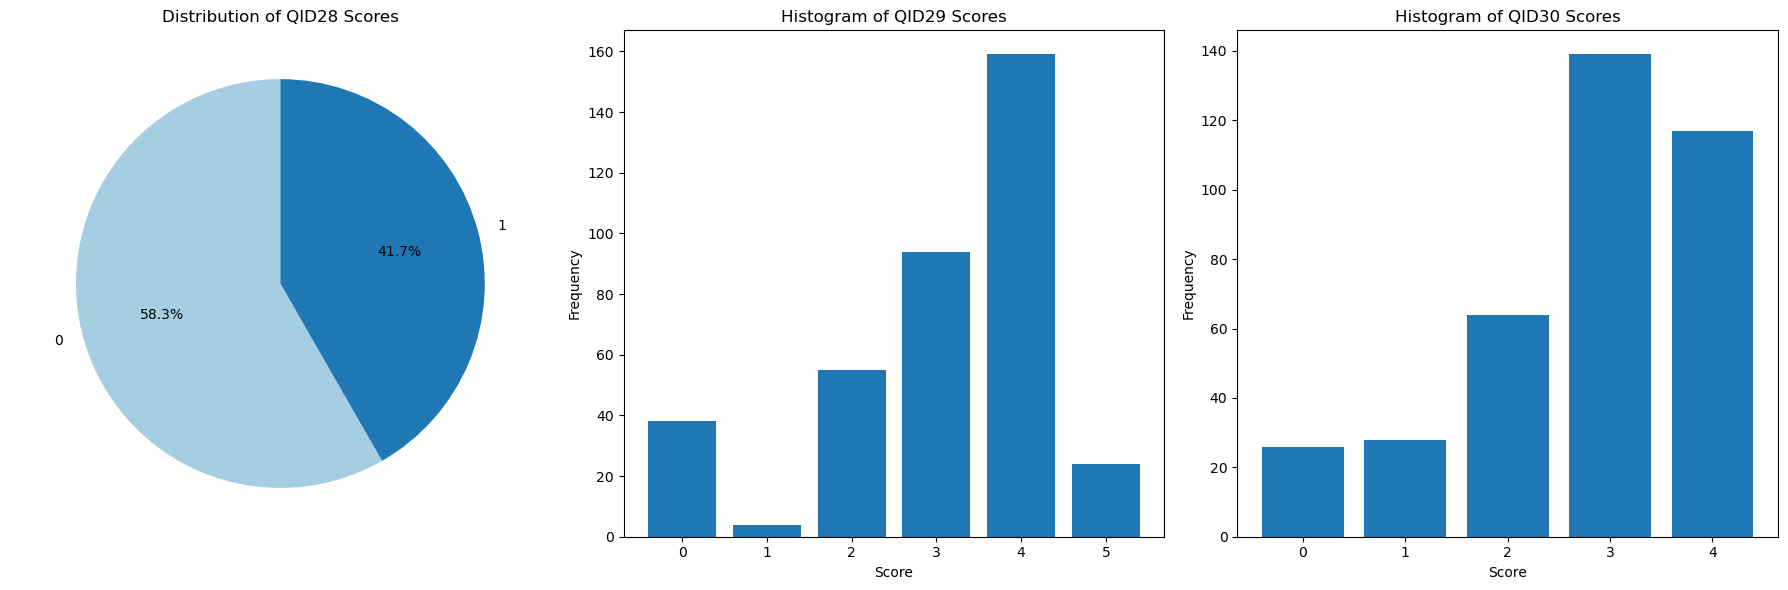

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for QID28_Score
qid28_scores = df['QID28_Score'].value_counts()
axs[0].pie(qid28_scores, labels=qid28_scores.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axs[0].set_title('Distribution of QID28 Scores')
axs[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Histogram for QID29_Score
labels, counts = np.unique(df['QID29_Score'], return_counts=True)
axs[1].bar(labels, counts, align='center')
axs[1].set_xticks(labels)
axs[1].set_title('Histogram of QID29 Scores')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Frequency')

# Histogram for QID30_Score
labels, counts = np.unique(df['QID30_Score'], return_counts=True)
axs[2].bar(labels, counts, align='center')
axs[2].set_title('Histogram of QID30 Scores')
axs[2].set_xticks(labels)
axs[2].set_xlabel('Score')
axs[2].set_ylabel('Frequency')

# Display the subplots
plt.tight_layout()
plt.show()

Do people who are more confident actually score higher?

In [35]:
likert_knowledgeable_mapping = {
    'Not knowledgeable at all': 1,
    'Slightly knowledgeable': 2,
    'Moderately knowledgeable': 3,
    'Very knowledgeable': 4,
    'Extremely knowledgeable': 5
}

df_numeric = pd.DataFrame()
df_numeric['QID27'] = df['QID27'].map(likert_knowledgeable_mapping.get)
df_numeric['QID28_Score'] = df['QID28_Score']
df_numeric['QID29_Score'] = df['QID29_Score']
df_numeric['QID30_Score'] = df['QID30_Score']

print(f"== QID28. {QID_to_question('QID28')} ==")
stat, p_value = stats.spearmanr(df_numeric['QID27'], df_numeric['QID28_Score'])

# Output the results
print(f'Spearman’s correlation coefficient: {stat}')
print(f'p-value: {p_value}')

== QID28. What type of messages do you believe a chatbot on [QID5-ChoiceGroup-SelectedChoices] has access to? ==
Spearman’s correlation coefficient: -0.05773389707777678
p-value: 0.265402690127845


In [36]:
print(f"== QID29. {QID_to_question('QID29')} ==")
stat, p_value = stats.spearmanr(df_numeric['QID27'], df_numeric['QID29_Score'])

# Output the results
print(f'Spearman’s correlation coefficient: {stat}')
print(f'p-value: {p_value}')

# fig, ax = plt.subplots(figsize=(5, 5))
# sns.heatmap(pd.crosstab(df_numeric['QID27'], df_numeric['QID29_Score']).reindex(columns=range(0, 6), fill_value=0), cbar_kws=dict(label='Count'), ax=ax)
# plt.xlabel('Score')
# plt.ylabel('Confidence')
# ax.invert_yaxis()

== QID29. Following up on the previous question, what information do you believe is included with the message a chatbot has access to on [QID5-ChoiceGroup-SelectedChoices]? Select all that apply. ==
Spearman’s correlation coefficient: 0.07859386323509118
p-value: 0.12921800334902878


In [37]:
print(f"== QID30. {QID_to_question('QID30')} ==")
stat, p_value = stats.spearmanr(df_numeric['QID27'], df_numeric['QID30_Score'])

# Output the results
print(f'Spearman’s correlation coefficient: {stat}')
print(f'p-value: {p_value}')

== QID30. What type of information do you believe a chatbot on [QID5-ChoiceGroup-SelectedChoices] can access about the group? Select all that apply. ==
Spearman’s correlation coefficient: 0.1453838932310833
p-value: 0.0048450146010466716


### User's Privacy Concerns About Chatbot Permission

#### Without Discord:

In [38]:
df_no_discord = df[df['QID5'] != 'Discord']
df_no_discord.shape

(291, 99)

In [39]:
print(QID_to_question("QID83"))
print(QID_to_question("QID33"))

likert_mapping = {
    'Strongly disagree': 1,
    'Somewhat disagree': 2,
    'Neither agree nor disagree': 3,
    'Somewhat agree': 4,
    'Strongly agree': 5
}

# Applying the mapping to the DataFrame
df_numeric_no_discord = df_no_discord[["QID83", "QID33"]].map(likert_mapping.get)

# Perform the Wilcoxon signed-rank test
stat, p_value = stats.wilcoxon(df_numeric_no_discord['QID83'], df_numeric_no_discord['QID33'])

# Output the results
print(f'Wilcoxon signed-rank test statistic: {stat}')
print(f'p-value: {p_value}')

Chatbots from group chats with access to users’ data as checked above would raise my privacy concerns.
Chatbots from group chats with access to users’ data as listed above would raise my privacy concerns.
Wilcoxon signed-rank test statistic: 2261.5
p-value: 0.00046460740249200415


(291, 99)

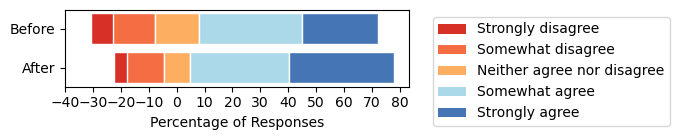

In [40]:
plot_likert(df_no_discord[["QID83", "QID33"]], likert_agree_order, question_labels=["Before", "After"], image_size=(7,1.5))
df_no_discord.shape

In [41]:
# Map the Likert scale
df_numeric_no_discord = df_no_discord[["QID83", "QID33"]].map(likert_mapping.get)

# Wilcoxon signed-rank test
stat, p_value = stats.wilcoxon(df_numeric_no_discord['QID83'], df_numeric_no_discord['QID33'])

# Calculate paired differences (after - before, adjust sign if needed)
diffs = df_numeric_no_discord['QID33'] - df_numeric_no_discord['QID83']

ci_lower = np.percentile(diffs, 2.5)
ci_upper = np.percentile(diffs, 97.5)

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"p-value: {p_value}")
print(f"Median difference: {np.median(diffs):.3f}")
print(f"95% bootstrap CI for median difference: [{ci_lower:.3f}, {ci_upper:.3f}]")

Wilcoxon signed-rank test statistic: 2261.5
p-value: 0.00046460740249200415
Median difference: 0.000
95% bootstrap CI for median difference: [-2.000, 3.000]


In [42]:
print(QID_to_question("QID83"))
print(QID_to_question("QID33"))

stat, p_value = stats.wilcoxon(df_numeric_no_discord['QID83'], df_numeric_no_discord['QID33'])

# Number of pairs (excluding zero differences)
n = np.sum(df_numeric_no_discord['QID83'] != df_numeric_no_discord['QID33'])

# Mean and standard deviation of Wilcoxon distribution
mean_W = n * (n + 1) / 4
sd_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

# Compute z-value
z = (stat - mean_W) / sd_W

# Effect size r
r = z / np.sqrt(n)

print(f"Wilcoxon statistic W: {stat}")
print(f"p-value: {p_value}")
print(f"Effect size r: {r}")


Chatbots from group chats with access to users’ data as checked above would raise my privacy concerns.
Chatbots from group chats with access to users’ data as listed above would raise my privacy concerns.
Wilcoxon statistic W: 2261.5
p-value: 0.00046460740249200415
Effect size r: -0.3087723465128705


In [43]:
df_numeric_no_discord['QID83'].describe()

count    291.000000
mean       3.666667
std        1.166585
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: QID83, dtype: float64

In [44]:
df_numeric_no_discord['QID33'].describe()

count    291.000000
mean       3.890034
std        1.169263
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: QID33, dtype: float64

In [45]:
value_counts = df_no_discord[["QID33", "QID34", "QID35", "QID36"]].apply(pd.Series.value_counts).fillna(0)

# Ensure all Likert scale values are present
value_counts = value_counts.reindex(likert_mapping.keys())

# Sort according to Likert scale
value_counts["Likert Score"] = value_counts.index.map(likert_mapping)
value_counts = value_counts.sort_values("Likert Score").drop(columns=["Likert Score"])
value_counts

,QID33,QID34,QID35,QID36
Strongly disagree,12,16,14,25
Somewhat disagree,39,38,41,71
Neither agree nor disagree,27,23,37,72
Somewhat agree,104,91,97,83
Strongly agree,109,123,102,40


In [46]:
percentage_counts = (value_counts / value_counts.sum()) * 100
percentage_counts

,QID33,QID34,QID35,QID36
Strongly disagree,4.123711,5.498282,4.810997,8.591065
Somewhat disagree,13.402062,13.058419,14.089347,24.398625
Neither agree nor disagree,9.278351,7.903780,12.714777,24.742268
Somewhat agree,35.738832,31.271478,33.333333,28.522337
Strongly agree,37.457045,42.268041,35.051546,13.745704


In [47]:
[QID_to_question("QID33"), QID_to_question("QID34"), QID_to_question("QID35"), QID_to_question("QID36")]

['Chatbots from group chats with access to users’ data as listed above would raise my privacy concerns.',
 'I would be concerned that any personal information I share in the group chat could be collected by the chatbot and be used inappropriately.',
 'I would stop sharing some sensitive information or talking about controversial topics in group chat because of privacy concerns about chatbots.',
 'I would still use the chatbot after knowing what information it had access to.']

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

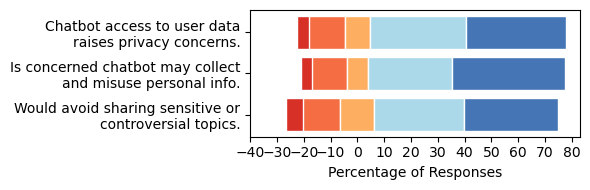

In [48]:
question_labels = [
    'Chatbot access to user data\nraises privacy concerns.',
    'Is concerned chatbot may collect\nand misuse personal info.',
    'Would avoid sharing sensitive or\ncontroversial topics.',]
plt = plot_likert(df_no_discord[["QID33", "QID34", "QID35"]], likert_agree_order, title="", question_labels=question_labels, image_size=(6, 2), legend=False)
plt.savefig('figures/concerns.pdf')
plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

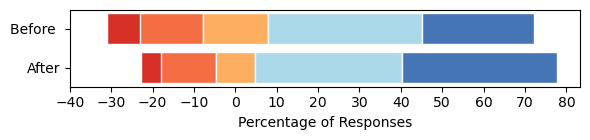

In [49]:
plt = plot_likert(df_no_discord[["QID83", "QID33"]], likert_agree_order, question_labels=["Before ", "After"], image_size=(6, 1.5), legend=False)
plt.savefig('figures/concerns-before-after.pdf')
plt

In [50]:
value_counts = df_no_discord[["QID33", "QID83"]].apply(pd.Series.value_counts).fillna(0)

# Ensure all Likert scale values are present
value_counts = value_counts.reindex(likert_mapping.keys())

# Sort according to Likert scale
value_counts["Likert Score"] = value_counts.index.map(likert_mapping)
value_counts = value_counts.sort_values("Likert Score").drop(columns=["Likert Score"])
print(value_counts)

                            QID33  QID83
Strongly disagree              12     14
Somewhat disagree              39     44
Neither agree nor disagree     27     46
Somewhat agree                104    108
Strongly agree                109     79


In [51]:
percentage_counts = (value_counts / value_counts.sum()) * 100
print(percentage_counts)

                                QID33      QID83
Strongly disagree            4.123711   4.810997
Somewhat disagree           13.402062  15.120275
Neither agree nor disagree   9.278351  15.807560
Somewhat agree              35.738832  37.113402
Strongly agree              37.457045  27.147766


## Ranking of Importance

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_rankings(
    df,
    question_prefix="QID44",
    max_rank=5,
    title="Ranking Diverging Bar Chart",
    image_size=(8, 4),
    option_labels=None,
    legend=True
):
    """
    Plot a diverging stacked bar chart for ranking data (1..max_rank).
    Rank #1 is plotted at the far right, Rank #max_rank at the far left.
    If there's a center rank (e.g., 3 of 1..5), it is centered at x=0.
    
    Parameters
    ----------
    df : pd.DataFrame
        Each column is named like '{question_prefix}_1', '{question_prefix}_2', ...
        Each cell has an integer rank (1 = best, 5 = worst, for example).
    question_prefix : str
        Common prefix for the columns that belong to this question.
    max_rank : int
        The maximum rank, e.g. 5 if participants rank from 1..5.
    title : str
        Plot title.
    image_size : tuple
        (width, height) in inches.
    option_labels : list
        Custom labels for each option. If None, we use column suffixes.
    legend : bool
        Whether to display a legend.
    """

    # 1) Identify the relevant columns (e.g. QID44_1, QID44_2, etc.)
    question_cols = [c for c in df.columns if c.startswith(question_prefix + "_")]
    if not question_cols:
        print(f"No columns found with prefix '{question_prefix}_'.")
        return None, None

    # 2) If no custom labels, use the suffix (e.g. '1', '2', etc.) as labels
    if option_labels is None:
        option_labels = [col.replace(question_prefix + "_", "") for col in question_cols]

    # 3) For each option, compute the percentage of responses that gave each rank
    #    We'll get a DataFrame (rows=ranks 1..max_rank, columns=options).
    rank_counts = []
    for col in question_cols:
        col_counts = df[col].value_counts(normalize=True) * 100
        col_counts = col_counts.reindex(range(1, max_rank+1), fill_value=0)
        rank_counts.append(col_counts)
    counts_df = pd.concat(rank_counts, axis=1)
    counts_df.columns = option_labels

    # 4) Determine which ranks are "better", "neutral", and "worse"
    #    Example: If max_rank=5, we define:
    #       better = [1, 2], neutral = [3], worse = [4, 5].
    midpoint = (max_rank + 1) / 2.0  # e.g. 3 if max_rank=5
    all_ranks = counts_df.index

    better_ranks  = [r for r in all_ranks if r <  midpoint]  # e.g. 1, 2
    neutral_ranks = [r for r in all_ranks if r == midpoint]  # e.g. 3
    worse_ranks   = [r for r in all_ranks if r >  midpoint]  # e.g. 4, 5

    df_better  = counts_df.loc[better_ranks]  if better_ranks else pd.DataFrame()
    df_neutral = counts_df.loc[neutral_ranks] if neutral_ranks else pd.DataFrame()
    df_worse   = counts_df.loc[worse_ranks]   if worse_ranks else pd.DataFrame()

    # 5) Define colors for each rank segment (adjust to taste)
    #    We'll define them in the order from worst->best, 
    #    but we’ll apply them in reverse if we want rank#5 on the left, rank#1 on the right.
    #    Example palette:
    worse_colors  = ['#f46d43', '#d73027']  # rank4, rank5
    neutral_color = '#fdae61'               # rank3
    better_colors = ['#abd9e9', '#4575b4']  # rank2, rank1

    fig, ax = plt.subplots(figsize=image_size)

    # Reverse the order of the options so that the first is on top
    reversed_options = list(reversed(option_labels))

    # 6) Plot each option as a horizontal diverging bar
    for opt in reversed_options:
        # The y-position label
        y_label = opt

        # We'll find the percentage for each rank. 
        # Example if better_ranks=[1,2], df_better has rows for rank=1,2
        # In the code below, we place rank #3 in the center (split half left, half right).
        neutral_value = 0
        if not df_neutral.empty:
            neutral_value = df_neutral.loc[neutral_ranks[0], opt]
        neutral_half = neutral_value / 2.0

        # 6a) Plot the "worse" ranks to the left of center
        #     We stack from the edge of the neutral bar going further left.
        left_edge = -neutral_half
        # We want rank#4 closer to center, rank#5 further left, 
        # so we iterate in ascending order (4 then 5).
        for rank in sorted(worse_ranks):
            width = df_worse.loc[rank, opt]
            ax.barh(
                y_label,
                -width,           # negative, going left
                left=left_edge,   # start from left_edge
                color=worse_colors[rank - worse_ranks[0]],  # pick color by index offset
                edgecolor='white'
            )
            left_edge -= width

        # 6b) Plot the neutral rank (#3) so that half is on left, half is on right
        if neutral_value > 0:
            ax.barh(
                y_label,
                neutral_value, 
                left=-neutral_half,  # extends from -half to +half
                color=neutral_color,
                edgecolor='white'
            )

        # 6c) Plot the "better" ranks to the right of center
        #     We start from +neutral_half and move right.
        right_edge = neutral_half
        # We want rank#2 closer to center, rank#1 further right, 
        # so we iterate in descending order (2 then 1).
        for rank in sorted(better_ranks, reverse=True):
            width = df_better.loc[rank, opt]
            ax.barh(
                y_label,
                width,           # positive, going right
                left=right_edge, # start from right_edge
                color=better_colors[better_ranks[-1] - rank],  # pick color by offset
                edgecolor='white'
            )
            right_edge += width

    # 7) Compute how far left & right we need to go
    #    The worst side is negative (rank#4,5) + half neutral
    #    The best side is positive (rank#1,2) + half neutral
    # We take the maximum sum across all options
    max_left = 0
    max_right = 0
    for opt in option_labels:
        # sum of "worse" ranks for this option
        w_sum = df_worse[opt].sum() if not df_worse.empty else 0
        # sum of "better" ranks for this option
        b_sum = df_better[opt].sum() if not df_better.empty else 0
        # neutral half
        n_half = 0
        if not df_neutral.empty:
            n_val = df_neutral.loc[neutral_ranks[0], opt]
            n_half = n_val / 2.0

        left_extent  = w_sum + n_half
        right_extent = b_sum + n_half

        if left_extent  > max_left:  max_left  = left_extent
        if right_extent > max_right: max_right = right_extent

    # Round up to a nice number
    max_extent = max(max_left, max_right)
    max_extent_rounded = int((max_extent // 10) + 1) * 10
    ax.set_xlim(-max_extent_rounded, max_extent_rounded)

    # 8) Labeling and formatting
    ax.set_xlabel("Percentage of Responses (%)")
    ax.set_ylabel("Option")
    ax.set_title(title)
    # Put the first option at the top
    ax.invert_yaxis()
    
    # 9) Construct a legend in numerical order: Rank 1 at top, then 2, ..., Rank N at bottom.
    all_legend_ranks = sorted(better_ranks + neutral_ranks + worse_ranks)
    legend_handles = []
    for rank in all_legend_ranks:
        if rank in better_ranks:
            # For better ranks, we use: index = better_ranks[-1] - rank 
            # (so for better_ranks [1,2], Rank 1 gets index 1, Rank 2 gets index 0)
            color = better_colors[better_ranks[-1] - rank]
        elif rank in worse_ranks:
            # For worse ranks, we use: index = rank - worse_ranks[0]
            color = worse_colors[rank - worse_ranks[0]]
        else:  # neutral ranks
            color = neutral_color
        legend_handles.append(Patch(facecolor=color, label=f"Rank {rank}"))
    
    if legend:
        ax.legend(
            handles=legend_handles,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            title="Ranks"
        )


    plt.tight_layout()
    return fig, ax

### General Case

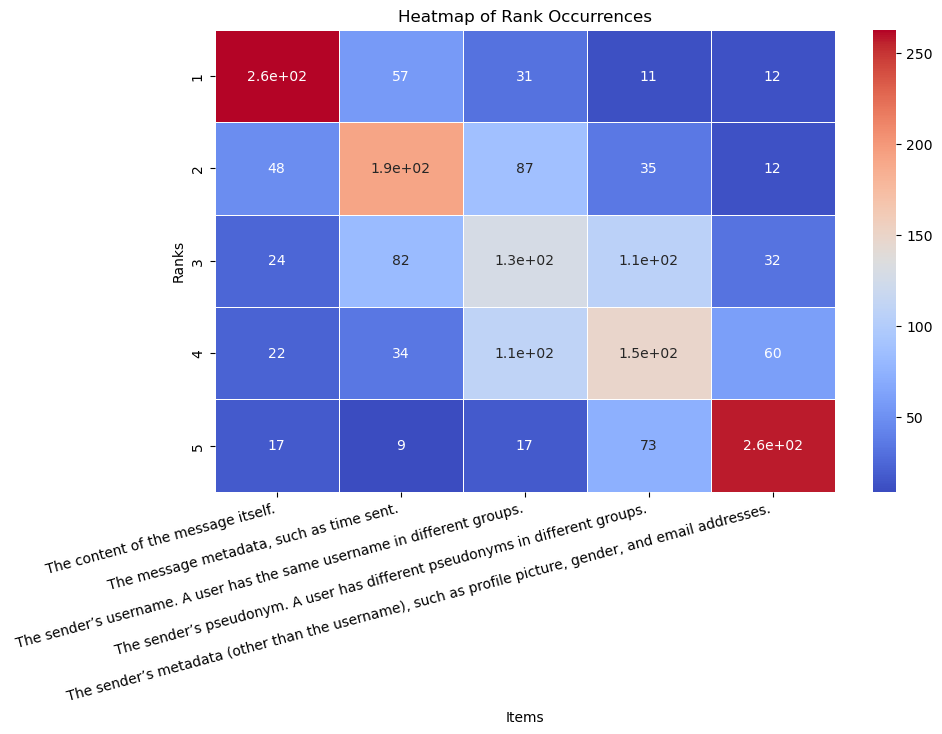

In [53]:
# Create a DataFrame to count occurrences of each rank for each item
rank_counts = pd.DataFrame()

for column in df[['QID44_1', 'QID44_2', 'QID44_3', 'QID44_4', 'QID44_5']].columns:
    rank_counts[column] = df[column].value_counts().sort_index()

# Replace NaN with 0 where any rank did not occur for an item
rank_counts = rank_counts.fillna(0)
rank_counts.columns = [QID_to_question(col).split('-')[1] for col in rank_counts.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(rank_counts, annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title('Heatmap of Rank Occurrences')
plt.xlabel('Items')
plt.ylabel('Ranks')
plt.xticks(rotation=15, ha='right')
plt.show()

Ideally, what type of messages do you expect a chatbot in a group chat has access to? - Selected Choice


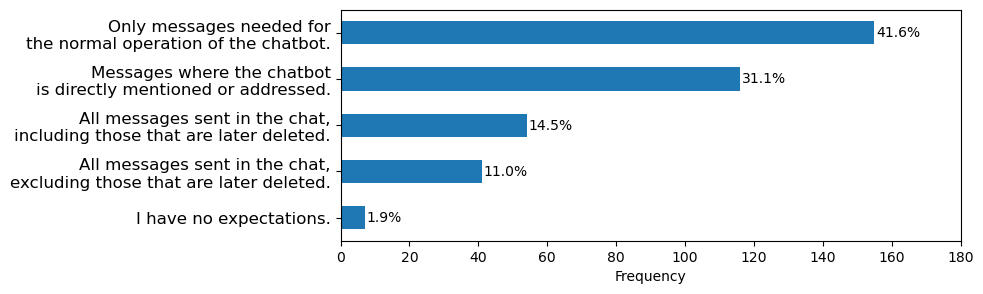

In [54]:
print(QID_to_question('QID43'))


# Define the custom labels with newlines
responses_split = {
    "All messages sent in the chat, including those that are later deleted.": 
        "All messages sent in the chat,\nincluding those that are later deleted.",
    "All messages sent in the chat, excluding those that are later deleted.": 
        "All messages sent in the chat,\nexcluding those that are later deleted.",
    "Only messages needed for the normal operation of the chatbot.": 
        "Only messages needed for\nthe normal operation of the chatbot.",
    "Messages where the chatbot is directly mentioned or addressed.": 
        "Messages where the chatbot\nis directly mentioned or addressed.",
    "I have no expectations.": 
        "I have no expectations."
}

# Get response counts and sort them
response_counts = df['QID43'].value_counts().drop("Other (please specify)", errors='ignore')
response_counts = response_counts.sort_values(ascending=True)  # Sorting

# Ensure labels match sorted response_counts
sorted_labels = [responses_split[label] for label in response_counts.index]

# Calculate percentages
total_responses = response_counts.sum()
percentages = (response_counts / total_responses) * 100

# Plot
plt.figure(figsize=(8, 3))
ax = response_counts.plot(kind='barh')

# Set the y-ticks with custom labels
ax.set_yticks(range(len(sorted_labels)))
ax.set_yticklabels(sorted_labels, fontsize=12)

# Add percentage text
for index, value in enumerate(response_counts):
    percentage = f"{percentages.iloc[index]:.1f}%"
    plt.text(value + 0.5, index, percentage, va='center')

# Labels and title
plt.ylabel('')
plt.xlabel('Frequency')
ax.set_xticks(np.arange(0, 181, 20))
plt.show()

Ideally, what specific information within a message would you expect a chatbot to have access to? Sort all options according to your level of expectation, with 1 being the most expected to be accessible, and 5 being least expected to be accessible. - The content of the message itself.


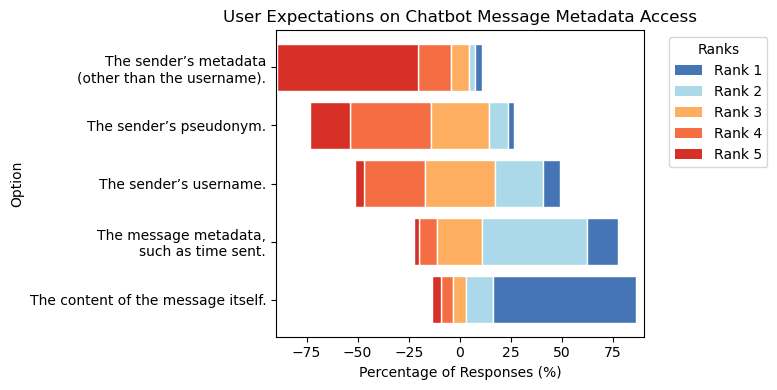

In [55]:
print(QID_to_question('QID44_1'))
fig, ax = plot_rankings(
    df,
    question_prefix="QID44",
    max_rank=5,
    title="User Expectations on Chatbot Message Metadata Access",
    image_size=(8, 4),
    option_labels=["The content of the message itself.",
        "The message metadata,\nsuch as time sent.",
        "The sender’s username.",
        "The sender’s pseudonym.",
        "The sender’s metadata\n(other than the username)."
    ],
    legend=True
)
plt.show()

Ideally, what information about the group itself would you expect a chatbot to be able to have access to? Sort all options according to your level of expectation, with 1 being the most expected to be accessible, and 4 being least expected to be accessible. - The name of the group.


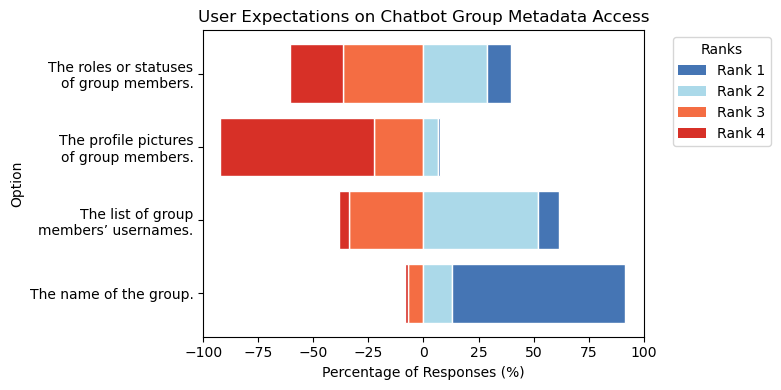

In [56]:
print(QID_to_question('QID45_1'))
fig, ax = plot_rankings(
    df,
    question_prefix="QID45",
    max_rank=4,
    title="User Expectations on Chatbot Group Metadata Access",
    image_size=(8, 4),
    option_labels=[
        "The name of the group.",
        "The list of group\nmembers’ usernames.",
        "The profile pictures\nof group members.",
        "The roles or statuses\nof group members."
    ],
    legend=True
)
plt.show()

### Reminder

Ideally, what type of messages do you expect Reminder has access to? - Selected Choice


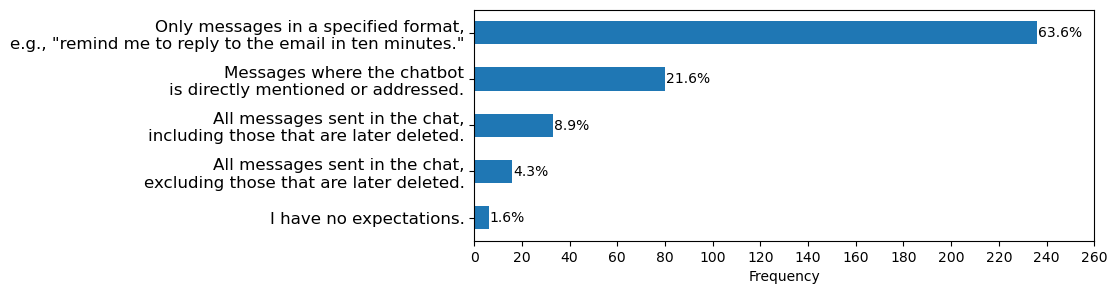

In [57]:
print(QID_to_question('QID53'))


# Define the custom labels with newlines
responses_split = {
    "All messages sent in the chat, including those that are later deleted.": 
        "All messages sent in the chat,\nincluding those that are later deleted.",
    "All messages sent in the chat, excluding those that are later deleted.": 
        "All messages sent in the chat,\nexcluding those that are later deleted.",
    "Only messages in a specified format, e.g., \"remind me to reply to the email in ten minutes.\"": 
        "Only messages in a specified format,\ne.g., \"remind me to reply to the email in ten minutes.\"",
    "Messages where the chatbot is directly mentioned or addressed.": 
        "Messages where the chatbot\nis directly mentioned or addressed.",
    "I have no expectations.": 
        "I have no expectations."
}

# Get response counts and sort them
response_counts = df['QID53'].value_counts().drop("Other (please specify)", errors='ignore')
response_counts = response_counts.sort_values(ascending=True)  # Sorting

# Ensure labels match sorted response_counts
sorted_labels = [responses_split[label] for label in response_counts.index]

# Calculate percentages
total_responses = response_counts.sum()
percentages = (response_counts / total_responses) * 100

# Plot
plt.figure(figsize=(8, 3))
ax = response_counts.plot(kind='barh')

# Set the y-ticks with custom labels
ax.set_yticks(range(len(sorted_labels)))
ax.set_yticklabels(sorted_labels, fontsize=12)

# Add percentage text
for index, value in enumerate(response_counts):
    percentage = f"{percentages.iloc[index]:.1f}%"
    plt.text(value + 0.5, index, percentage, va='center')

# Labels and title
plt.ylabel('')
plt.xlabel('Frequency')
ax.set_xticks(np.arange(0, 261, 20))
plt.show()

Ideally, what specific information within a message do you expect Reminder to have access to? Sort all options according to your level of expectation, with 1 being the most expected to be accessible, and 5 being least expected to be accessible. - The content of the message itself.


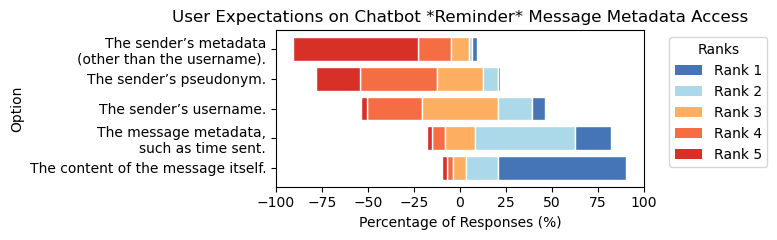

In [58]:
print(QID_to_question('QID54_1'))
fig, ax = plot_rankings(
    df,
    question_prefix="QID54",
    max_rank=5,
    title="User Expectations on Chatbot *Reminder* Message Metadata Access",
    image_size=(8, 2.5),
    option_labels=["The content of the message itself.",
        "The message metadata,\nsuch as time sent.",
        "The sender’s username.",
        "The sender’s pseudonym.",
        "The sender’s metadata\n(other than the username)."
    ],
    legend=True
)
plt.show()

Ideally, what information about the group itself do you expect Reminder to be able to have access to? Sort all options according to your level of expectation, with 1 being the most expected to be accessible, and 4 being least expected to be accessible. - The name of the group.


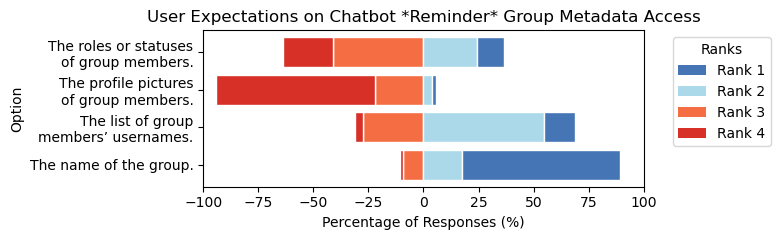

In [59]:
print(QID_to_question('QID55_1'))
fig, ax = plot_rankings(
    df,
    question_prefix="QID55",
    max_rank=4,
    title="User Expectations on Chatbot *Reminder* Group Metadata Access",
    image_size=(8, 2.5),
    option_labels=[
        "The name of the group.",
        "The list of group\nmembers’ usernames.",
        "The profile pictures\nof group members.",
        "The roles or statuses\nof group members."
    ],
    legend=True
)
plt.show()

### Moderation Helper

Ideally, what type of messages do you expect Moderation Helper has access to? - Selected Choice


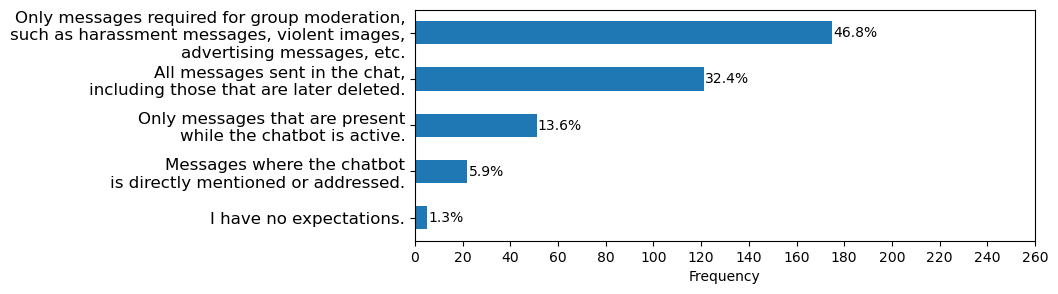

In [60]:
print(QID_to_question('QID57'))


# Define the custom labels with newlines
responses_split = {
    "All messages sent in the chat, including those that are later deleted.": 
        "All messages sent in the chat,\nincluding those that are later deleted.",
    "Only messages that are present while the chatbot is active.": 
        "Only messages that are present\nwhile the chatbot is active.",
    "Only messages required for group moderation, such as harassment messages, violent images, advertising messages, etc.": 
        "Only messages required for group moderation,\nsuch as harassment messages, violent images,\nadvertising messages, etc.",
    "Messages where the chatbot is directly mentioned or addressed.": 
        "Messages where the chatbot\nis directly mentioned or addressed.",
    "I have no expectations.": 
        "I have no expectations."
}

# Get response counts and sort them
response_counts = df['QID57'].value_counts().drop("Other (please specify)", errors='ignore')
response_counts = response_counts.sort_values(ascending=True)  # Sorting

# Ensure labels match sorted response_counts
sorted_labels = [responses_split[label] for label in response_counts.index]

# Calculate percentages
total_responses = response_counts.sum()
percentages = (response_counts / total_responses) * 100

# Plot
plt.figure(figsize=(8, 3))
ax = response_counts.plot(kind='barh')

# Set the y-ticks with custom labels
ax.set_yticks(range(len(sorted_labels)))
ax.set_yticklabels(sorted_labels, fontsize=12)

# Add percentage text
for index, value in enumerate(response_counts):
    percentage = f"{percentages.iloc[index]:.1f}%"
    plt.text(value + 0.5, index, percentage, va='center')

# Labels and title
plt.ylabel('')
plt.xlabel('Frequency')
ax.set_xticks(np.arange(0, 261, 20))
plt.show()

Ideally, what specific information within a message would you expect Moderation Helper to have access to? Sort all options according to your level of expectation, with 1 being the most expected to be accessible, and 5 being least expected to be accessible. - The content of the message itself.


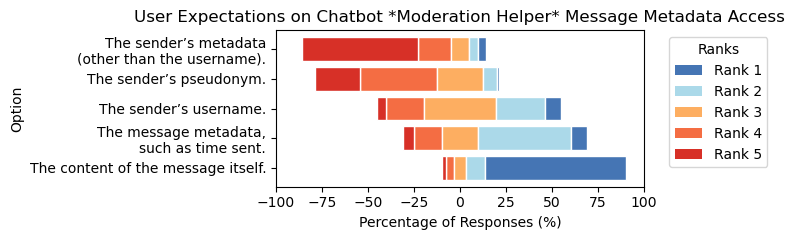

In [61]:
print(QID_to_question('QID58_1'))
fig, ax = plot_rankings(
    df,
    question_prefix="QID58",
    max_rank=5,
    title="User Expectations on Chatbot *Moderation Helper* Message Metadata Access",
    image_size=(8, 2.5),
    option_labels=["The content of the message itself.",
        "The message metadata,\nsuch as time sent.",
        "The sender’s username.",
        "The sender’s pseudonym.",
        "The sender’s metadata\n(other than the username)."
    ],
    legend=True
)
plt.show()

Ideally, what information about the group itself would you expect Moderation Helper to be able to have access to? Sort all options according to your level of expectation, with 1 being the most expected to be accessible, and 4 being least expected to be accessible. - The name of the group.


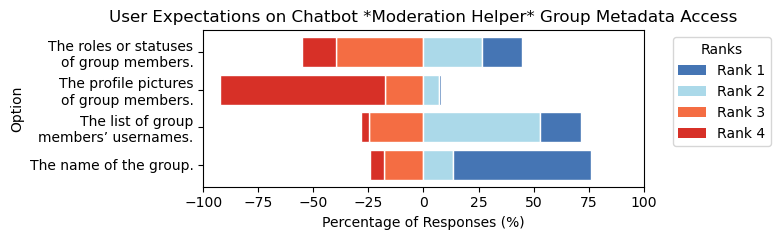

In [62]:
print(QID_to_question('QID59_1'))
fig, ax = plot_rankings(
    df,
    question_prefix="QID59",
    max_rank=4,
    title="User Expectations on Chatbot *Moderation Helper* Group Metadata Access",
    image_size=(8, 2.5),
    option_labels=[
        "The name of the group.",
        "The list of group\nmembers’ usernames.",
        "The profile pictures\nof group members.",
        "The roles or statuses\nof group members."
    ],
    legend=True
)
plt.show()

## Demographics

In [63]:
response_counts = df['QID63'].value_counts()
response_counts

QID63
25 - 34    160
18 - 24    131
35 - 44     48
45 - 54     22
55 - 64      6
65 - 74      4
75 - 84      2
Name: count, dtype: int64

QID64
Male          191
Female        176
Non-binary      2
Name: count, dtype: int64


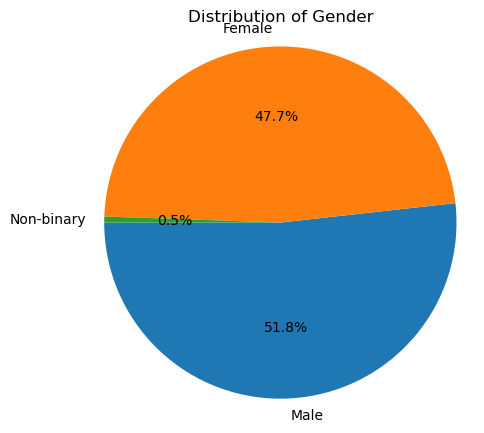

In [64]:
response_counts = df['QID64'].value_counts()
print(response_counts)

plt.figure(figsize=(5, 5))
plt.pie(response_counts, labels=response_counts.index, autopct='%1.1f%%', startangle=180)
plt.title('Distribution of Gender')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the chart
plt.show()

Highest level of education completed
QID65
Less than high school                       7
High school graduate                       49
Some college but no degree                 52
Associate’s degree in college (2-year)     15
Bachelor’s degree in college (4-year)     181
Master’s degree                            56
Professional degree (JD, MD, etc.)          4
Doctorate                                   7
Name: count, dtype: int64


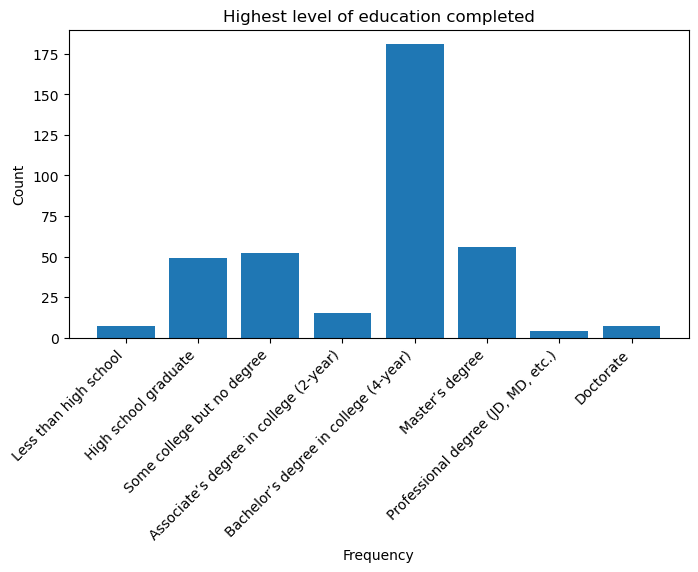

In [65]:
print(QID_to_question('QID65'))


frequency_order = ['Less than high school', 'High school graduate', 'Some college but no degree', 'Associate’s degree in college (2-year)', 'Bachelor’s degree in college (4-year)', 'Master’s degree', 'Professional degree (JD, MD, etc.)', 'Doctorate']
frequency_counts = df['QID65'].value_counts().sort_values(ascending=False)
frequency_counts_sorted = frequency_counts.reindex(frequency_order)
print(frequency_counts_sorted)

plt.figure(figsize=(8, 4))
plt.bar(frequency_counts_sorted.index, frequency_counts_sorted.values)
plt.xticks(rotation=45, ha='right')
plt.title('Highest level of education completed')
plt.xlabel('Frequency')
plt.ylabel('Count')

# Show the chart
plt.show()

Race and ethnicity - Selected Choice
QID67
American Indian or Alaska Native      1.0
Asian                                26.0
Black or African American           153.0
Hispanic or Latino                   28.0
Mixed race                           11.0
Pacific Islander                      NaN
White or Caucasian                  141.0
Prefer to self-describe               8.0
Name: count, dtype: float64


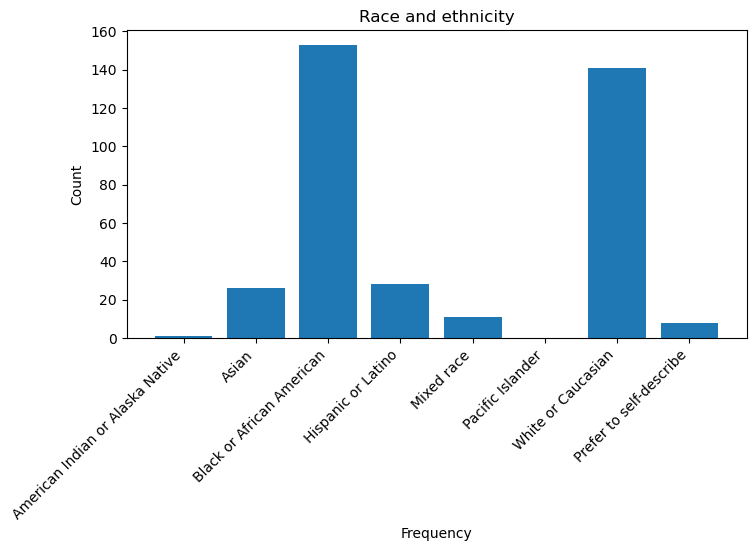

In [66]:
print(QID_to_question('QID67'))

frequency_order = ['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Hispanic or Latino', 'Mixed race', 'Pacific Islander', 'White or Caucasian', 'Prefer to self-describe']
frequency_counts = df['QID67'].value_counts().sort_values(ascending=False)
frequency_counts_sorted = frequency_counts.reindex(frequency_order)
print(frequency_counts_sorted)

plt.figure(figsize=(8, 4))
plt.bar(frequency_counts_sorted.index, frequency_counts_sorted.values)
plt.xticks(rotation=45, ha='right')
plt.title('Race and ethnicity')
plt.xlabel('Frequency')
plt.ylabel('Count')

# Show the chart
plt.show()

Technical work experience
QID66
Yes    235
No     131
Name: count, dtype: int64


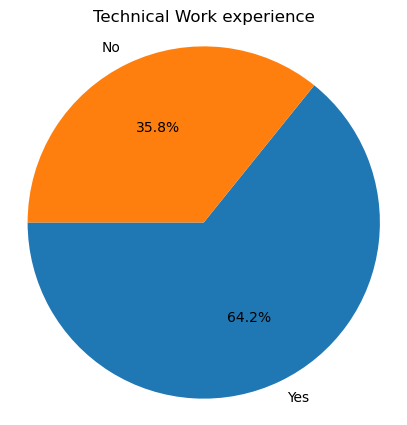

In [67]:
response_counts = df['QID66'].value_counts()
print(QID_to_question('QID66'))
print(response_counts)

plt.figure(figsize=(5, 5))
plt.pie(response_counts, labels=response_counts.index, autopct='%1.1f%%', startangle=180)
plt.title('Technical Work experience')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the chart
plt.show()

In [68]:
%pip freeze

aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1696765453792/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1694690212886/work
altair @ file:///home/conda/feedstock_root/build_artifacts/altair_1696364485230/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1693488585952/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386580812/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1696128962909/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1694046349000/work
async-generator==1.10
async-lru @ file:///home/conda/feedstock_root/build_artifacts/async-lru_1690563019058/work
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-